In [1]:
!pip install torch_geometric

In [2]:
!pip install torch

In [3]:
import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as masking
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import json
import os
import collections

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import itertools
from itertools import combinations 


import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 

from sklearn import metrics
 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch_geometric.data import Data
from torch_geometric.data import DataLoader as DataLoaderGraph
from torch_geometric.data import Dataset as DatasetGraph
from torch_geometric.data import Batch as BatchGraph
from torch_geometric.transforms import RandomNodeSplit as masking

from torch_geometric.nn import GCNConv, BatchNorm, SAGEConv, SGConv, ChebConv
from torch_geometric.utils.convert import to_networkx

import networkx as nx


In [2]:
with open(r"facebook_large\\facebook_large\\musae_facebook_features.json") as json_data:
    data_raw = json.load(json_data)

edges=pd.read_csv("D:\RISHWANTH\ACADS\YEAR 3\\facebook_large\\facebook_large\musae_facebook_edges.csv")
target_df=pd.read_csv(r"D:\\RISHWANTH\ACADS\\YEAR 3\\facebook_large\\facebook_large\\musae_facebook_target.csv")#.to_numpy()[:,2]

In [3]:
target_df.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [4]:
target_df.tail(5)

,id,facebook_id,page_name,page_type
22465,22465,1379955382222841,Kurt Wiegel MdL,politician
22466,22466,1651527995097082,dubdub Stories,company
22467,22467,155369444540412,Ministerio del Interior - Paraguay,government
22468,22468,175067819212798,Tottus Perú,company
22469,22469,27208897877,SPORT1 Doppelpass,tvshow


In [5]:
target_df.page_type

0            tvshow
1        government
2           company
3        government
4        politician
            ...    
22465    politician
22466       company
22467    government
22468       company
22469        tvshow
Name: page_type, Length: 22470, dtype: object

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()



# Create the OneHotEncoder object (optional: specify handle_unknown='ignore' for new categories)
encoder = LabelEncoder()

# Fit the encoder on the 'page_type' column
encoded_df = encoder.fit_transform(target_df['page_type'])
target_df['page_type']=encoded_df

In [7]:
target_df.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,3
1,1,191483281412,U.S. Consulate General Mumbai,1
2,2,144761358898518,ESET,0
3,3,568700043198473,Consulate General of Switzerland in Montreal,1
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,2


In [8]:
target_df.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,3
1,1,191483281412,U.S. Consulate General Mumbai,1
2,2,144761358898518,ESET,0
3,3,568700043198473,Consulate General of Switzerland in Montreal,1
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,2


In [9]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]


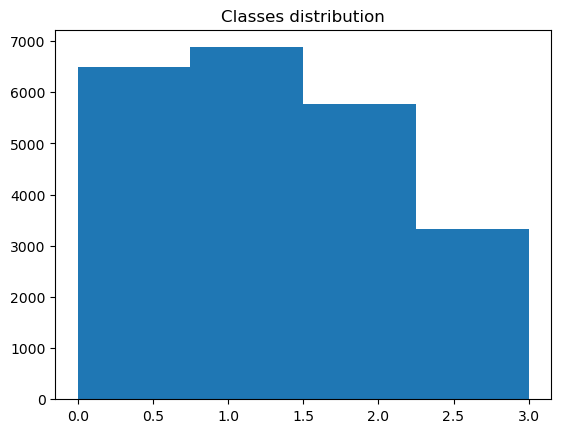

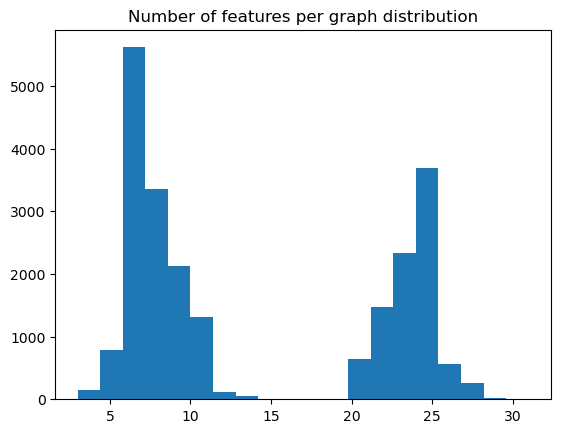

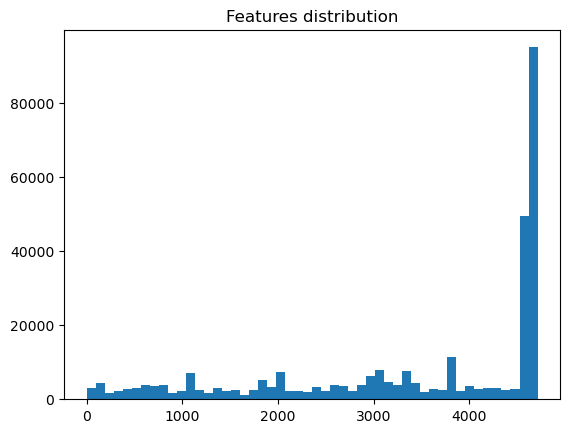

In [10]:
plt.hist(target_df.page_type,bins=4,);
plt.title("Classes distribution")
plt.show()

plt.hist(feat_counts,bins=20)
plt.title("Number of features per graph distribution")
plt.show()

plt.hist(feats,bins=50)
plt.title("Features distribution")
plt.show()


In [11]:
counter=collections.Counter(feats)
print(list(counter.keys())[:10])
print(list(counter.values())[:10])
print(list(counter.keys())[-10:])
print(list(counter.values())[-10:])

[3133, 3825, 236, 874, 1072, 143, 1078, 901, 3399, 597]
[1843, 801, 699, 273, 1186, 492, 26, 39, 462, 353]
[1738, 255, 1628, 611, 1780, 3848, 3914, 3443, 965, 3544]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [12]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    
    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

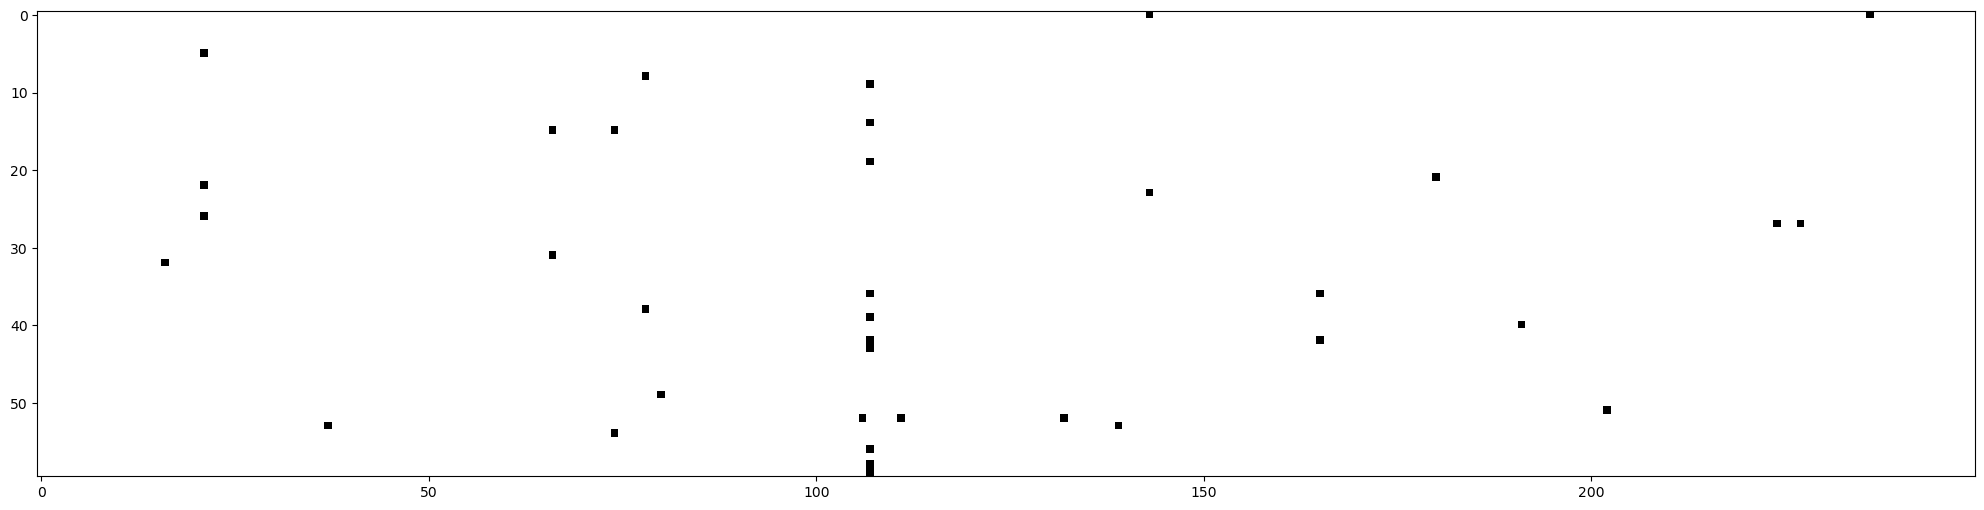

In [13]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');

In [14]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['page_type'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [15]:
def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
        
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")
        

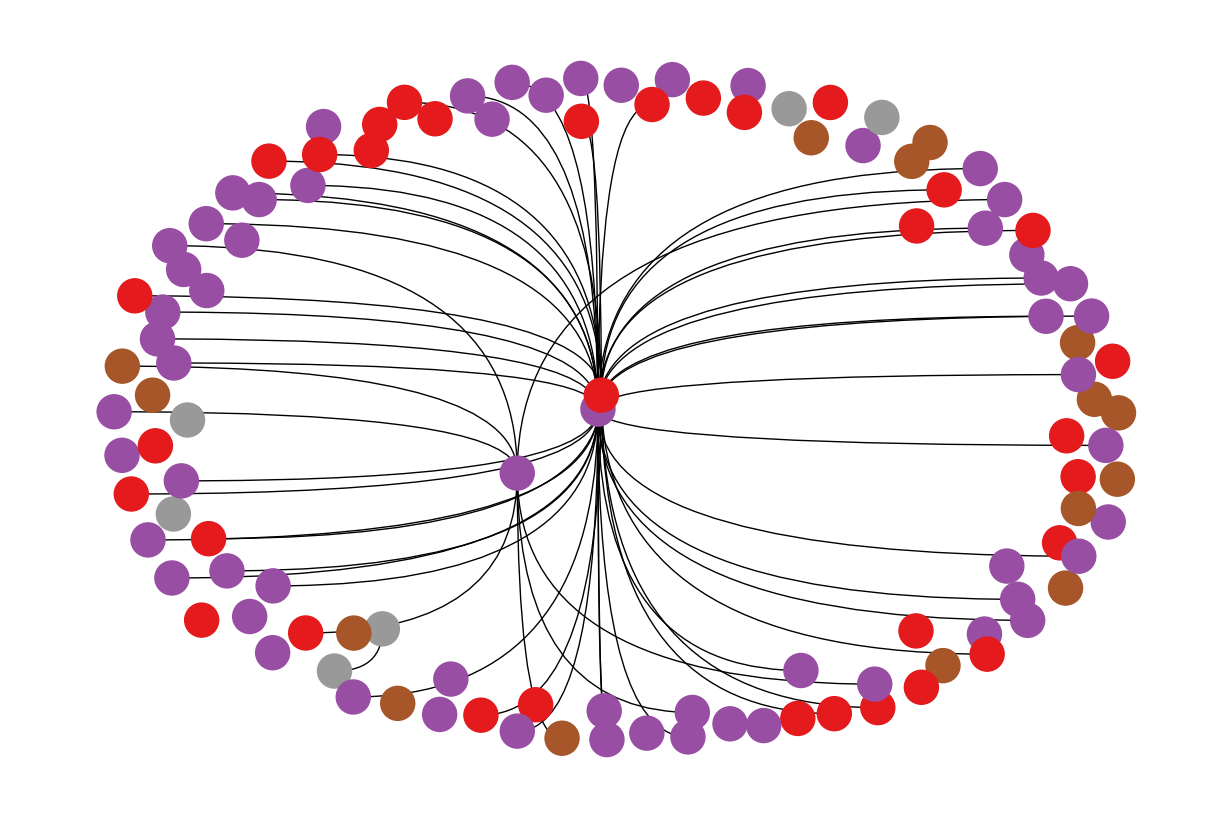

In [16]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)

In [18]:
data_encoded,_=encode_data(light=False)

In [19]:
g=construct_graph(data_encoded=data_encoded,light=False)

In [20]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
g=msk(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

Data(x=[22470, 4714], edge_index=[2, 342004], y=[22470], train_mask=[22470], val_mask=[22470], test_mask=[22470])

training samples 2247
validation samples 6741
test samples 13482


In [21]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()


        self.conv1 = GCNConv(num_of_feat, f)

        self.conv2 = GCNConv(f,4)


    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
          
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        return x

In [26]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    prediction=predictions.type(torch.LongTensor)
    labels = labels.type(torch.LongTensor)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss) 

In [27]:
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)    

In [28]:
def train_social(net,data,epochs=2,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    
    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]
    
    for ep in range(epochs+1):
        optimizer.zero_grad()
        out=net(data)
        # print(data.y.shape)
        # print(out.shape)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]
        
        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss]
        
        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy]

        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy
    plt.plot(np.array([loss.detach().numpy() for loss in train_losses]))
    plt.plot(np.array([loss.detach().numpy() for loss in val_losses]))
    plt.plot(np.array([loss.detach().numpy() for loss in test_losses]))

    plt.show()
    
    plt.plot(train_accuracies) 
    plt.plot(val_accuracies)
    plt.plot(test_accuracies) 
    plt.show()

Epoch 1/50, Train_Loss: 1.3834, Train_Accuracy: 0.2701, Val_Accuracy: 0.2707, Test_Accuracy: 0.2790
Epoch 2/50, Train_Loss: 1.3139, Train_Accuracy: 0.4860, Val_Accuracy: 0.4484, Test_Accuracy: 0.4704
Epoch 3/50, Train_Loss: 0.7828, Train_Accuracy: 0.7032, Val_Accuracy: 0.6929, Test_Accuracy: 0.6937
Epoch 4/50, Train_Loss: 0.5766, Train_Accuracy: 0.8144, Val_Accuracy: 0.8202, Test_Accuracy: 0.8192
Epoch 5/50, Train_Loss: 0.4753, Train_Accuracy: 0.8371, Val_Accuracy: 0.8419, Test_Accuracy: 0.8384
Epoch 6/50, Train_Loss: 0.3723, Train_Accuracy: 0.8803, Val_Accuracy: 0.8855, Test_Accuracy: 0.8810
Epoch 7/50, Train_Loss: 0.3007, Train_Accuracy: 0.9070, Val_Accuracy: 0.9064, Test_Accuracy: 0.9068
Epoch 8/50, Train_Loss: 0.2648, Train_Accuracy: 0.9137, Val_Accuracy: 0.9116, Test_Accuracy: 0.9161
Epoch 9/50, Train_Loss: 0.2593, Train_Accuracy: 0.9177, Val_Accuracy: 0.9151, Test_Accuracy: 0.9142
Epoch 10/50, Train_Loss: 0.2504, Train_Accuracy: 0.9194, Val_Accuracy: 0.9205, Test_Accuracy: 0.9212

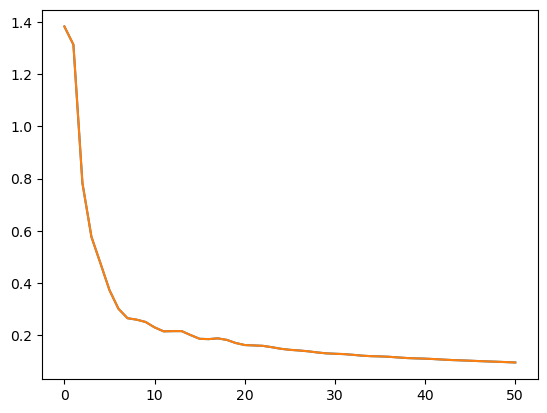

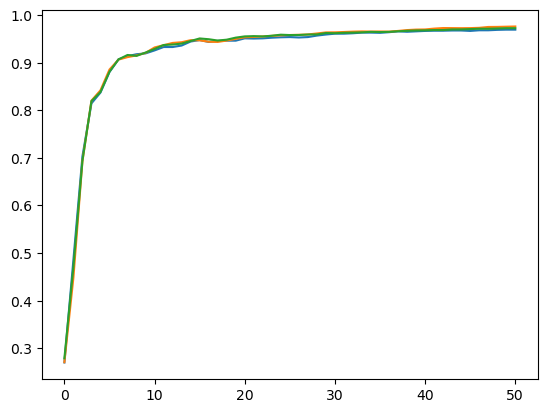

In [29]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
train_social(net,g,epochs=50,lr=0.1)